In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json
from typing import Dict, List, Tuple
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch  
from scipy.ndimage import gaussian_filter1d

plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [8.0, 6.0],
    'figure.dpi': 300,
    'font.size': 10,
    'svg.fonttype': 'none',
    'figure.titlesize': 9,
    'axes.titlesize': 9,
    'axes.labelsize': 8,
    'ytick.labelsize': 7,
    'xtick.labelsize': 7,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})

In [2]:
 # Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Setup paths
scratch_dir = os.getenv("SCRATCH_DIR")

In [3]:
# Base directory for analysis outputs
OUTPUT_DIR = Path(scratch_dir) / "output"
SAVE_DIR = Path(OUTPUT_DIR) / "00_final_figures"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Groups and their data paths
GROUPS = ['affair', 'paranoia', 'combined']

# Colors for plotting
COLORS = {
    'affair': '#e41a1c',      # Red
    'affair_light': '#ff6666', # Light red
    'paranoia': '#4daf4a',    # Green
    'paranoia_light': '#90ee90', # Light green
    'combined': '#984ea3',    # Purple
    'combined_light': '#d8b2d8' # Light purple
}

In [4]:
SAVE_DIR_FIG4 = Path(SAVE_DIR) / "figure4"
SAVE_DIR_FIG4.mkdir(parents=True, exist_ok=True)

# Content features

In [59]:
def create_tr_raster_plot(annotations_file: str, save_path: str, label: bool = False) -> plt.Figure:
    """Create raster plot of story features at TR level."""
    # Read data
    df = pd.read_csv(annotations_file)
    
    # Filter to only include features that exist in the dataframe
    binary_features = ['has_adj', 'has_adv', 'has_noun', 'has_verb', 'arthur_speaking', 
                     'girl_speaking', 'lee_speaking', 'lee_girl_together']
    binary_features = sorted(binary_features)
 
    # Create figure with single plot
    fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))
    
    # Use tab10 colormap
    from matplotlib.cm import tab10
    colors = [tab10(i) for i in range(len(binary_features))]
    
    # Plot binary features
    for idx, (feature, color) in enumerate(zip(binary_features, colors)):
        mask = df[feature].astype(bool)
        if mask.any():
            ax.vlines(df.loc[mask, 'TR'], 
                      idx - 0.2, idx + 0.2,
                      color=color, linewidth=1)
    
    # Customize binary features plot
    ax.set_xticks([])
    if label:
        # ax.set_yticks([])
        ax.set_yticks(range(len(binary_features)))
        ax.set_yticklabels([f.replace('_', ' ').title() for f in binary_features])
        save_path = save_path + '_label'
    else:
        ax.set_yticks([])
        save_path = save_path + '_nolabel'
    
    ax.set_xlim(0, df['TR'].max())
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.set_xlabel('Time (TR)')
    # ax.set_title('Story Features', pad=10)
    
    plt.tight_layout()
    plt.savefig(SAVE_DIR_FIG4 / f'{save_path}.png', dpi=300, bbox_inches='tight')
    plt.savefig(SAVE_DIR_FIG4 / f'{save_path}.svg', dpi=300, bbox_inches='tight')
    plt.close()
    return fig

In [60]:
data_dir = os.path.join(scratch_dir, 'data', 'stimuli')
content_file = Path(data_dir) / "10_story_annotations_tr.csv"

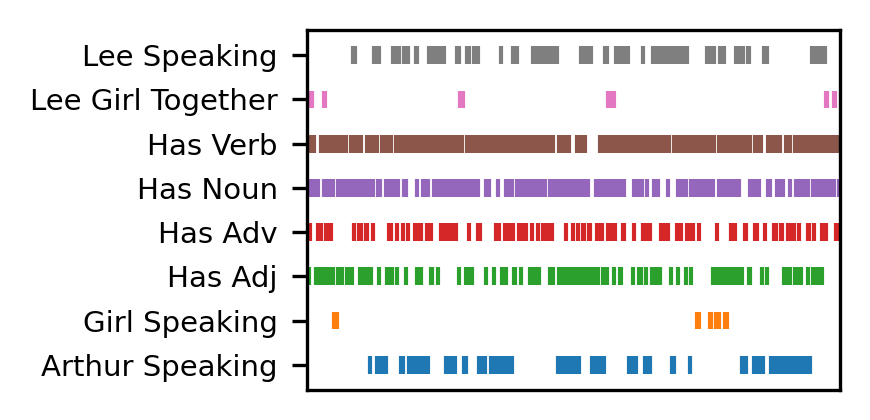

In [61]:
create_tr_raster_plot(content_file, 'content_tr_raster_plot', label=True)

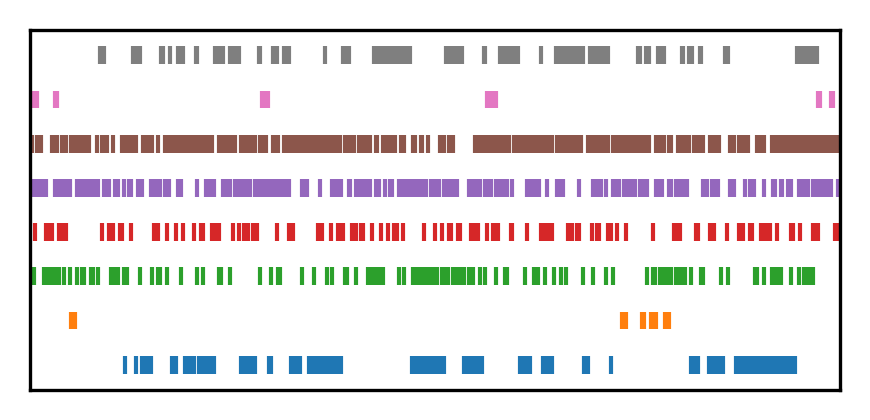

In [62]:
create_tr_raster_plot(content_file, 'content_tr_raster_plot', label=False)

# Brain state time series

In [5]:
def load_cluster_sequences(data_dir: str | Path, cluster_id: str, model_pattern: str) -> tuple[np.ndarray, np.ndarray]:
    """
    Load and split cluster sequence data into affair and paranoia groups.
    
    Args:
        data_dir: Directory containing the sequence files
        cluster_id: Cluster identifier (e.g., "1")
        model_pattern: Pattern for model states (e.g., "2states")
    
    Returns:
        tuple: (affair_data, paranoia_data) as numpy arrays
    """
    # Convert data_dir to Path object if it's a string
    data_dir = Path(data_dir)
    
    # Construct the sequence file path
    folder_name = f"th_085_combined_{model_pattern}_cluster{cluster_id}"
    sequence_file = data_dir / folder_name / f"cluster_{cluster_id}_sequences.npy"
    
    # Load the data
    try:
        data = np.load(sequence_file)
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find sequence file: {sequence_file}")
    
    # Get number of subjects and split the data
    n_subjects = data.shape[0]
    affair_data = data[:n_subjects//2, :]
    paranoia_data = data[n_subjects//2:, :]
    
    return affair_data, paranoia_data

In [6]:
def plot_temporal_dynamics(affair_data, paranoia_data, save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 1.25), sharex=True)
    

    # Plot affair profile
    ax.plot(np.mean(affair_data, axis=0),
            color=COLORS['affair'],
        #     label='Affair',
            linewidth=1)
    
    # Plot paranoia profile
    ax.plot(np.mean(paranoia_data, axis=0),
            color=COLORS['paranoia'],
        #     label='Paranoia ',
            linewidth=1)
    
    ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_xlabel('Time (TRs)')
    
    # ax.set_ylabel('State Probability')
    # ax.legend()
    
    # Set y-axis limits
    ax.set_ylim(0, 1.1)
    ax.set_yticklabels([])
    
    # Make x-axis start from 0
    
    ax.set_xlim(0, affair_data.shape[1] - 1)

    plt.tight_layout()

    if save_path:
        plt.savefig(SAVE_DIR_FIG4 / f'{save_path}.png', dpi=300, bbox_inches='tight')
        plt.savefig(SAVE_DIR_FIG4 / f'{save_path}.svg',  bbox_inches='tight')

    plt.close()
    return fig

In [7]:
data_dir = Path(OUTPUT_DIR) / "07_extracted_cluster_data"

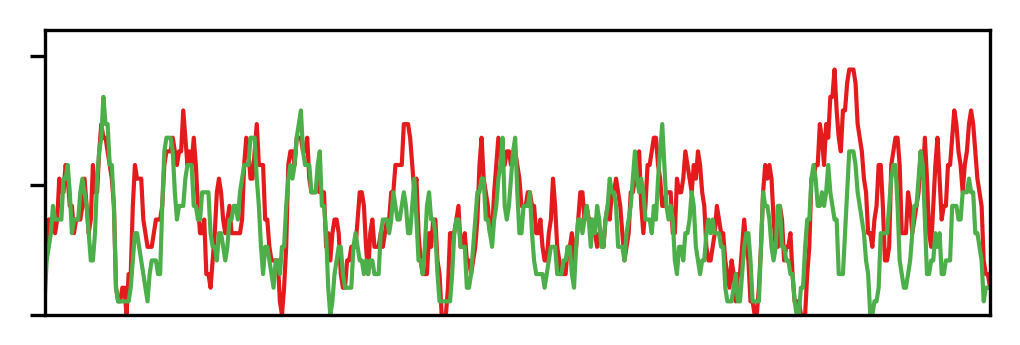

In [9]:
affair_seq_cluster1, paranoia_seq_cluster1 = load_cluster_sequences(data_dir, cluster_id="1", model_pattern="2states")
plot_temporal_dynamics(affair_seq_cluster1, paranoia_seq_cluster1, save_path="temporal_dynamics_2states_cluster1")
affair_seq_cluster1, paranoia_seq_cluster1 = load_cluster_sequences(data_dir, cluster_id="1", model_pattern="3states")
plot_temporal_dynamics(affair_seq_cluster1, paranoia_seq_cluster1, save_path="temporal_dynamics_3states_cluster1")
affair_seq_cluster1, paranoia_seq_cluster1 = load_cluster_sequences(data_dir, cluster_id="1", model_pattern="4states")
plot_temporal_dynamics(affair_seq_cluster1, paranoia_seq_cluster1, save_path="temporal_dynamics_4states_cluster1")
affair_seq_cluster1, paranoia_seq_cluster1 = load_cluster_sequences(data_dir, cluster_id="1", model_pattern="5states")
plot_temporal_dynamics(affair_seq_cluster1, paranoia_seq_cluster1, save_path="temporal_dynamics_5states_cluster1")

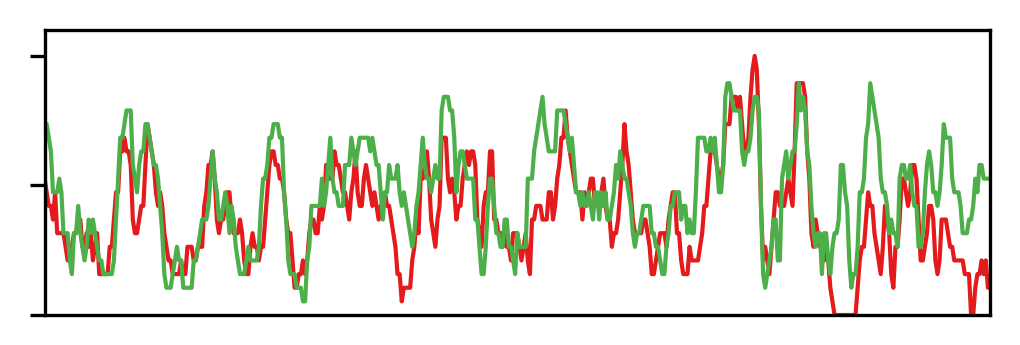

In [10]:
affair_seq_cluster3, paranoia_seq_cluster3 = load_cluster_sequences(data_dir, cluster_id="3", model_pattern="2states")
plot_temporal_dynamics(affair_seq_cluster3, paranoia_seq_cluster3, save_path="temporal_dynamics_2states_cluster3")

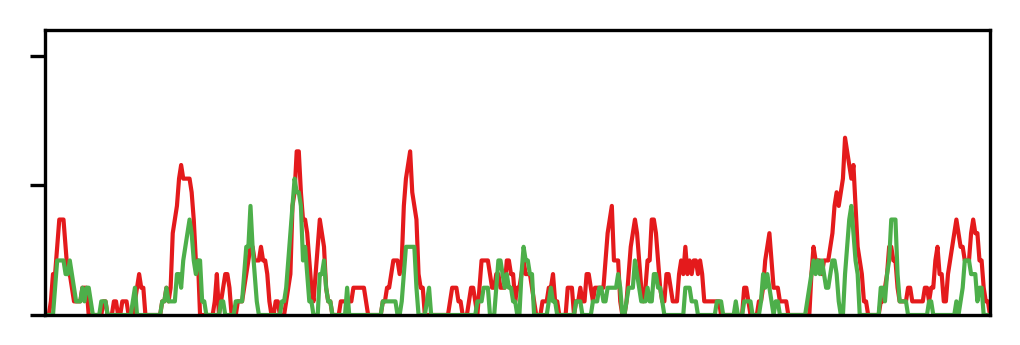

In [11]:
affair_seq_cluster2, paranoia_seq_cluster2 = load_cluster_sequences(data_dir, cluster_id="2", model_pattern="12states")
plot_temporal_dynamics(affair_seq_cluster2, paranoia_seq_cluster2, save_path="temporal_dynamics_12states_cluster2")

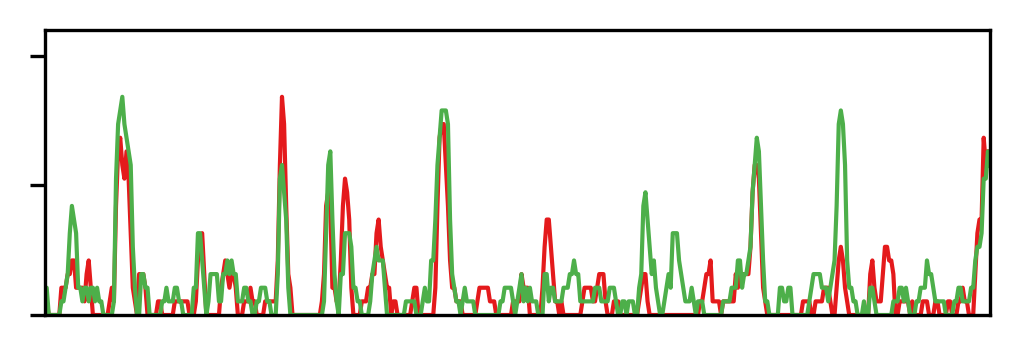

In [12]:
affair_seq_cluster4, paranoia_seq_cluster4 = load_cluster_sequences(data_dir, cluster_id="4", model_pattern="8states")
plot_temporal_dynamics(affair_seq_cluster4, paranoia_seq_cluster4, save_path="temporal_dynamics_8states_cluster4")

# GLMM results

In [8]:
def load_glmm_results(output_dir: str | Path, 
                     cluster_id: int, 
                     data_type: str = "combined", 
                     model_pattern: str = "2states", 
                     threshold: float = 0.85) -> np.ndarray:
    """
    Load GLMM results for a specific cluster and model configuration.
    
    Args:
        output_dir: Base output directory path
        cluster_id: Cluster identifier (e.g., 1)
        data_type: Type of data analysis (e.g., "combined", "affair", "paranoia")
        model_pattern: Pattern for model states (e.g., "2states")
        threshold: Threshold value used in analysis (default: 0.85)
    
    Returns:
        np.ndarray: GLMM results array
    
    Raises:
        FileNotFoundError: If the GLMM results file doesn't exist
        ValueError: If the results cannot be loaded properly
    """
    # Convert output_dir to Path object if it's a string
    output_dir = Path(output_dir)
    
    # Construct the GLMM folder path
    glmm_folder = output_dir / "09_brain_content_glmm" / f"cluster{cluster_id}_{data_type}_{model_pattern}_deviation_th{int(threshold*100):03d}"
    
    # Construct the results file path
    glmm_file = glmm_folder / "complete_results.npz"
    
    try:
        # Load the results
        results = np.load(glmm_file, allow_pickle=True)["results"]
        return results
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find GLMM results file: {glmm_file}")
    except Exception as e:
        raise ValueError(f"Error loading GLMM results: {str(e)}")

In [33]:
def plot_brain_state_effects(main_analysis, save_path=None, y_ticks=[0.6, 1.0, 1.5, 2.0], 
                             label=True, sort_by='effect_size', custom_feature_order=None,
                             group_names=None, colors=COLORS):
    """[0.6, 1.0, 1.5, 2.0]
    Create figure showing content feature effects for both groups in a single plot
    with different markers and color coding for significant effects.
    
    Parameters:
    -----------
    main_analysis : dict or numpy.ndarray
        Analysis results containing feature effects for different groups
    save_path : str, optional
        Path to save the figure
    label : bool, optional
        Whether to show feature labels on the plot
    sort_by : str, optional
        How to sort features: 'effect_size', 'alphabetical', or 'probability'
    custom_feature_order : list, optional
        Custom ordering of features to display
    group_names : dict, optional
        Dictionary mapping group keys to display names (e.g., {'affair_group': 'Context A'})
    colors : dict, optional
        Dictionary with custom colors for each group
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    # Set default group names if not provided
    if group_names is None:
        group_names = {
            'affair_group': 'Affair Group',
            'paranoia_group': 'Paranoia Group'
        }
    # Convert numpy array to dictionary if needed
    if isinstance(main_analysis, np.ndarray):
        results_dict = main_analysis.item()
    else:
        results_dict = main_analysis
    
    # Extract the feature_results from the structure
    if 'main_analysis' in results_dict and 'feature_results' in results_dict['main_analysis']:
        feature_results = results_dict['main_analysis']['feature_results']
    elif 'results' in results_dict and 'main_analysis' in results_dict['results']:
        feature_results = results_dict['results']['main_analysis']['feature_results']
    elif 'feature_results' in results_dict:
        feature_results = results_dict['feature_results']
    else:
        print("Structure keys:", list(results_dict.keys()))
        if 'results' in results_dict:
            print("Results keys:", list(results_dict['results'].keys()))
        raise ValueError("Could not find feature_results in the provided data structure")
    
    # Collect all available features
    all_features = list(feature_results.keys())
    
    print(f"Found {len(all_features)} features in data")
    
    # Data containers for each group
    affair_data = {
        'feature': [],
        'effect': [],
        'ci_lower': [],
        'ci_upper': [],
        'probability': []
    }
    
    paranoia_data = {
        'feature': [],
        'effect': [],
        'ci_lower': [],
        'ci_upper': [],
        'probability': []
    }
    
    # Populate data (using the same extraction logic as the original function)
    for feature in all_features:
        feature_data = feature_results[feature]
        
        # Skip if no group_specific_effects
        if 'group_specific_effects' not in feature_data:
            continue
            
        # Access group-specific effects
        group_specific = feature_data['group_specific_effects']
        
        # Special case: if we have a feature-specific structure with nested groups
        if len(group_specific) == 1 and feature in group_specific:
            # This is a special case where the feature is a key
            nested_group_data = group_specific[feature]
            
            # Add affair group data if it exists
            if 'affair_group' in nested_group_data and 'odds_ratio' in nested_group_data['affair_group']:
                affair_data['feature'].append(feature)
                affair_data['effect'].append(nested_group_data['affair_group'].get('odds_ratio', None))
                affair_data['ci_lower'].append(nested_group_data['affair_group'].get('lower', None))
                affair_data['ci_upper'].append(nested_group_data['affair_group'].get('upper', None))
                affair_data['probability'].append(nested_group_data['affair_group'].get('prob_positive', None))
            
            # Add paranoia group data if it exists
            if 'paranoia_group' in nested_group_data and 'odds_ratio' in nested_group_data['paranoia_group']:
                paranoia_data['feature'].append(feature)
                paranoia_data['effect'].append(nested_group_data['paranoia_group'].get('odds_ratio', None))
                paranoia_data['ci_lower'].append(nested_group_data['paranoia_group'].get('lower', None))
                paranoia_data['ci_upper'].append(nested_group_data['paranoia_group'].get('upper', None))
                paranoia_data['probability'].append(nested_group_data['paranoia_group'].get('prob_positive', None))
        else:
            # Standard case: direct group data
            if 'affair_group' in group_specific and 'odds_ratio' in group_specific['affair_group']:
                affair_data['feature'].append(feature)
                affair_data['effect'].append(group_specific['affair_group'].get('odds_ratio', None))
                affair_data['ci_lower'].append(group_specific['affair_group'].get('lower', None))
                affair_data['ci_upper'].append(group_specific['affair_group'].get('upper', None))
                affair_data['probability'].append(group_specific['affair_group'].get('prob_positive', None))
            
            # Add paranoia group data if it exists
            if 'paranoia_group' in group_specific and 'odds_ratio' in group_specific['paranoia_group']:
                paranoia_data['feature'].append(feature)
                paranoia_data['effect'].append(group_specific['paranoia_group'].get('odds_ratio', None))
                paranoia_data['ci_lower'].append(group_specific['paranoia_group'].get('lower', None))
                paranoia_data['ci_upper'].append(group_specific['paranoia_group'].get('upper', None))
                paranoia_data['probability'].append(group_specific['paranoia_group'].get('prob_positive', None))
    
    # Convert to DataFrames
    df_affair = pd.DataFrame(affair_data)
    df_paranoia = pd.DataFrame(paranoia_data)
    
    # If still no data, return empty figure
    if df_affair.empty and df_paranoia.empty:
        print("No valid data found for either group after all attempts")
        if label:
            fig, ax = plt.subplots(figsize=(3.5, 2))
        else:
            fig, ax = plt.subplots(figsize=(3.5, 1.25))
        ax.text(0.5, 0.5, "No valid data found for either group", 
                ha='center', va='center', fontsize=14)
        ax.axis('off')
        return fig
    
    # Determine common features between both groups
    common_features = set(df_affair['feature']).intersection(set(df_paranoia['feature']))
    
    # Filter to common features or use custom order if provided
    if custom_feature_order:
        # Filter to use only features in custom order
        df_affair = df_affair[df_affair['feature'].isin(custom_feature_order)]
        df_paranoia = df_paranoia[df_paranoia['feature'].isin(custom_feature_order)]
        
        # Sort according to custom order
        feature_order_dict = {f: i for i, f in enumerate(custom_feature_order)}
        df_affair['sort_key'] = df_affair['feature'].map(feature_order_dict)
        df_paranoia['sort_key'] = df_paranoia['feature'].map(feature_order_dict)
        
        df_affair = df_affair.sort_values('sort_key')
        df_paranoia = df_paranoia.sort_values('sort_key')
    else:
        # Filter to common features if needed
        if len(common_features) > 0:
            df_affair = df_affair[df_affair['feature'].isin(common_features)]
            df_paranoia = df_paranoia[df_paranoia['feature'].isin(common_features)]
        
        # Sort data if needed
        if sort_by == 'effect_size':
            # For combined plot, sort by overall effect magnitude
            if not df_affair.empty and not df_paranoia.empty:
                # Create a combined effect score
                common_features_list = list(common_features)
                effect_scores = {}
                
                for feature in common_features_list:
                    affair_effect = df_affair.loc[df_affair['feature'] == feature, 'effect'].values[0]
                    paranoia_effect = df_paranoia.loc[df_paranoia['feature'] == feature, 'effect'].values[0]
                    # Use maximum distance from 1 as sort key
                    effect_scores[feature] = max(abs(affair_effect - 1), abs(paranoia_effect - 1))
                
                # Sort both dataframes by this combined score
                sorted_features = sorted(effect_scores.keys(), 
                                        key=lambda f: effect_scores[f], 
                                        reverse=True)
                
                feature_order_dict = {f: i for i, f in enumerate(sorted_features)}
                
                df_affair['sort_key'] = df_affair['feature'].map(feature_order_dict)
                df_paranoia['sort_key'] = df_paranoia['feature'].map(feature_order_dict)
                
                df_affair = df_affair.sort_values('sort_key')
                df_paranoia = df_paranoia.sort_values('sort_key')
            else:
                # Sort each individually if only one has data
                if not df_affair.empty:
                    df_affair['sort_key'] = abs(df_affair['effect'] - 1)
                    df_affair = df_affair.sort_values('sort_key', ascending=False)
                if not df_paranoia.empty:
                    df_paranoia['sort_key'] = abs(df_paranoia['effect'] - 1)
                    df_paranoia = df_paranoia.sort_values('sort_key', ascending=False)
        elif sort_by == 'alphabetical':
            # Sort alphabetically
            df_affair = df_affair.sort_values('feature')
            df_paranoia = df_paranoia.sort_values('feature')
    
    if label:
        fig, ax = plt.subplots(figsize=(3.5, 2))
    else:
        fig, ax = plt.subplots(figsize=(3.5, 1.25))
    
    # Get all unique features from both dataframes
    all_plot_features = pd.concat([df_affair['feature'], df_paranoia['feature']]).unique()
    
    # Create x positions
    x_pos = np.arange(len(all_plot_features))
    feature_positions = {feature: i for i, feature in enumerate(all_plot_features)}
    
    # Plot reference line at odds ratio = 1 (no effect)
    ax.axhline(y=1, color='gray', linestyle='-', alpha=0.7, linewidth=0.5)
        
    def adjust_color_alpha(color, alpha_factor):
        """Adjust the alpha/intensity of a color"""
        rgb = mpl.colors.ColorConverter.to_rgb(color)
        return tuple([c * alpha_factor + (1-alpha_factor) for c in rgb])
    
    color_high_affair = colors['affair']
    color_med_affair = adjust_color_alpha(colors['affair'], 0.8)
    color_low_affair = adjust_color_alpha(colors['affair'], 0.5)
    gray_color = adjust_color_alpha('#777777', 0.6) 
    
    
    # Plot affair group data
    for i, (_, row) in enumerate(df_affair.iterrows()):
        feature_idx = feature_positions[row['feature']]
        
        # Check if CI crosses 1 (null effect for odds ratio)
        
        # Get the posterior probability
        prob = row['probability']
        
        # For odds ratios, probability should be interpreted as:
        # - If odds ratio > 1: probability that effect is positive
        # - If odds ratio < 1: probability that effect is negative
        # Ensure probability is always > 0.5 by taking max(p, 1-p)
        directional_prob = max(prob, 1-prob) if prob is not None else 0.5
        
        # Determine color based on directional probability
        if directional_prob > 0.999:
            point_color = color_high_affair
        elif directional_prob > 0.99:
            # point_color = color_med_affair  
            point_color = color_high_affair
        elif directional_prob > 0.95:
            # point_color = color_low_affair
            point_color = color_high_affair
        else:
            point_color = gray_color
        
        # Plot CI line
        ax.vlines(x=feature_idx - 0.15, ymin=row['ci_lower'], ymax=row['ci_upper'], 
                 color=point_color, alpha=0.7, linewidth=1)
        
        # Plot point - use "o" marker for affair group
        ax.scatter(feature_idx - 0.15, row['effect'], color=point_color, s=10, 
                  marker='o', zorder=3, label=group_names['affair_group'] if feature_idx == 0 else "")
        
        # # Add probability annotation if high confidence
        # if directional_prob > 0.99:
        #     text_y = row['ci_upper'] + (row['ci_upper'] - row['ci_lower']) * 0.1
        #     ax.text(x_pos[i]-0.15, text_y, f"{directional_prob:.3f}", 
        #             ha='center', va='bottom', fontsize=7, color=point_color, alpha=0.8)
    
    color_high_paranoia = colors['paranoia']
    color_med_paranoia = adjust_color_alpha(colors['paranoia'], 0.8)
    color_low_paranoia = adjust_color_alpha(colors['paranoia'], 0.5)
    
    # Plot paranoia group data
    for i, (_, row) in enumerate(df_paranoia.iterrows()):
        feature_idx = feature_positions[row['feature']]

        # Check if CI crosses 1 (null effect for odds ratio)
        ci_crosses_one = (row['ci_lower'] <= 1 and row['ci_upper'] >= 1)
        
        # Get the posterior probability
        prob = row['probability']
        
        # For odds ratios, probability should be interpreted as:
        # - If odds ratio > 1: probability that effect is positive
        # - If odds ratio < 1: probability that effect is negative
        # Ensure probability is always > 0.5 by taking max(p, 1-p)
        directional_prob = max(prob, 1-prob) if prob is not None else 0.5
        
        # Determine color based on directional probability
        if directional_prob > 0.999:
            point_color = color_high_paranoia   
        elif directional_prob > 0.99:
            # point_color = color_med_paranoia  
            point_color = color_high_paranoia
        elif directional_prob > 0.95:
            # point_color = color_low_paranoia
            point_color = color_high_paranoia
        else:
            point_color = gray_color
        
        # Determine color based on probability threshold
        # point_color = get_color(row['probability'], colors['paranoia'])
        
        # Plot CI line
        ax.vlines(x=feature_idx + 0.15, ymin=row['ci_lower'], ymax=row['ci_upper'], 
                 color=point_color, alpha=0.7, linewidth=1)
        
        # Plot point - use "^" marker for paranoia group
        ax.scatter(feature_idx + 0.15, row['effect'], color=point_color, s=10, 
                  marker='^', zorder=3, label=group_names['paranoia_group'] if feature_idx == 0 else "")
        
         # Add probability annotation if high confidence
        # if directional_prob > 0.99:
        #     text_y = row['ci_upper'] + (row['ci_upper'] - row['ci_lower']) * 0.1
        #     ax.text(x_pos[i]+0.15, text_y, f"{directional_prob:.3f}", 
        #             ha='center', va='bottom', fontsize=7, color=point_color, alpha=0.8)
    
    # Add legend
    # handles, labels = ax.get_legend_handles_labels()
    # # Remove duplicate labels
    # by_label = dict(zip(labels, handles))
    # ax.legend(by_label.values(), by_label.keys(), loc='upper left')
    
    
    # Use log scale for y-axis (better for odds ratios)
    ax.set_yscale('log')
    
    # Add x-axis labels
    if label:
         # Set y-axis label
        ax.set_ylabel("Odds Ratio")
        ax.set_xticks(x_pos)
        feature_labels = [f.replace('_', ' ').replace('has ', '').title() for f in all_plot_features]
        ax.set_xticklabels(feature_labels, rotation=90, ha='center')
    else:
         # Set y-axis label
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # Add title
    # ax.set_title("Brain State Effects by Group", fontsize=12)
    
    # Add grid
    ax.grid(axis='y', linestyle=':', alpha=0.3)
    
    # Set fixed y-ticks for better comparison
    
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([str(tick) for tick in y_ticks])
    
    # Calculate y-limits with padding
    if not df_affair.empty and not df_paranoia.empty:
        min_effect = min(df_affair['effect'].min(), df_paranoia['effect'].min())
        max_effect = max(df_affair['effect'].max(), df_paranoia['effect'].max())
        
        min_ci = min(df_affair['ci_lower'].min(), df_paranoia['ci_lower'].min())
        max_ci = max(df_affair['ci_upper'].max(), df_paranoia['ci_upper'].max())
    elif not df_affair.empty:
        min_effect = df_affair['effect'].min()
        max_effect = df_affair['effect'].max()
        min_ci = df_affair['ci_lower'].min()
        max_ci = df_affair['ci_upper'].max()
    else:
        min_effect = df_paranoia['effect'].min()
        max_effect = df_paranoia['effect'].max()
        min_ci = df_paranoia['ci_lower'].min()
        max_ci = df_paranoia['ci_upper'].max()
    
    global_min = min(min_effect, min_ci)
    global_max = max(max_effect, max_ci)
    
    # Add padding factor for log scale (multiplicative)
    padding_factor = 1.2
    global_y_min = global_min / padding_factor
    global_y_max = global_max * padding_factor
    
    ax.set_ylim(global_y_min, global_y_max)
    ax.set_xlim(-0.5, len(all_plot_features) - 0.5)
    
    plt.tight_layout()
    # Save figure if requested
    if save_path:
        suffix = "_label" if label else "_nolabel"
        plt.savefig(SAVE_DIR_FIG4 / f'{save_path}{suffix}.png', dpi=300, bbox_inches='tight')
        plt.savefig(SAVE_DIR_FIG4 / f'{save_path}{suffix}.svg', dpi=300, bbox_inches='tight')

    
    plt.close()
    return fig

In [19]:
plot_features = ['has_adj', 'has_adv', 'has_noun', 'has_verb', 'arthur_speaking', 
                     'girl_speaking', 'lee_speaking', 'arthur_adj', 'lee_girl_together', 
                     'lee_girl_verb']

Found 10 features in data


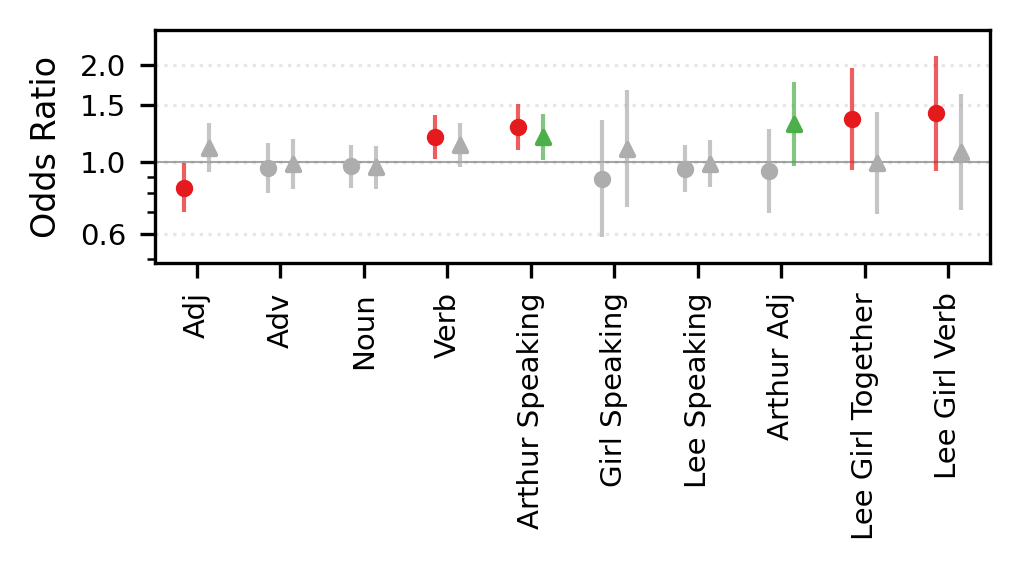

In [34]:

results1 = load_glmm_results(
    output_dir=OUTPUT_DIR,
    cluster_id=1,
    data_type="combined",
    model_pattern="2states"
)
plot_brain_state_effects(results1, custom_feature_order=plot_features, save_path="glmm_brain_2states_cluster1")

Found 10 features in data


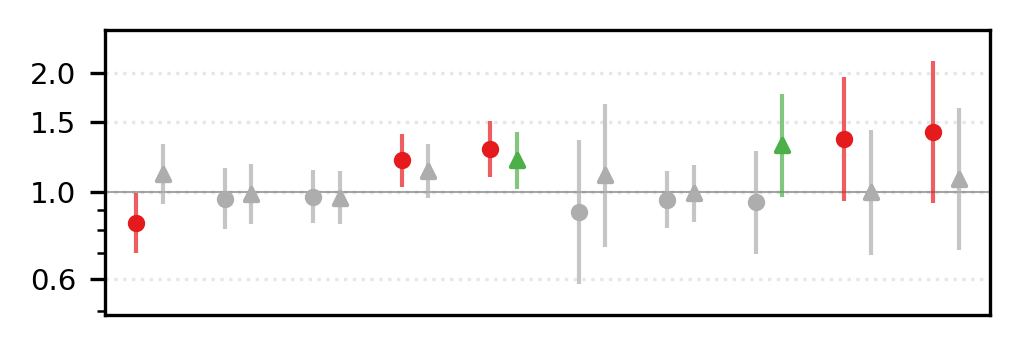

In [35]:
plot_brain_state_effects(results1, custom_feature_order=plot_features, label=False, save_path="glmm_brain_2states_cluster1")


Found 10 features in data


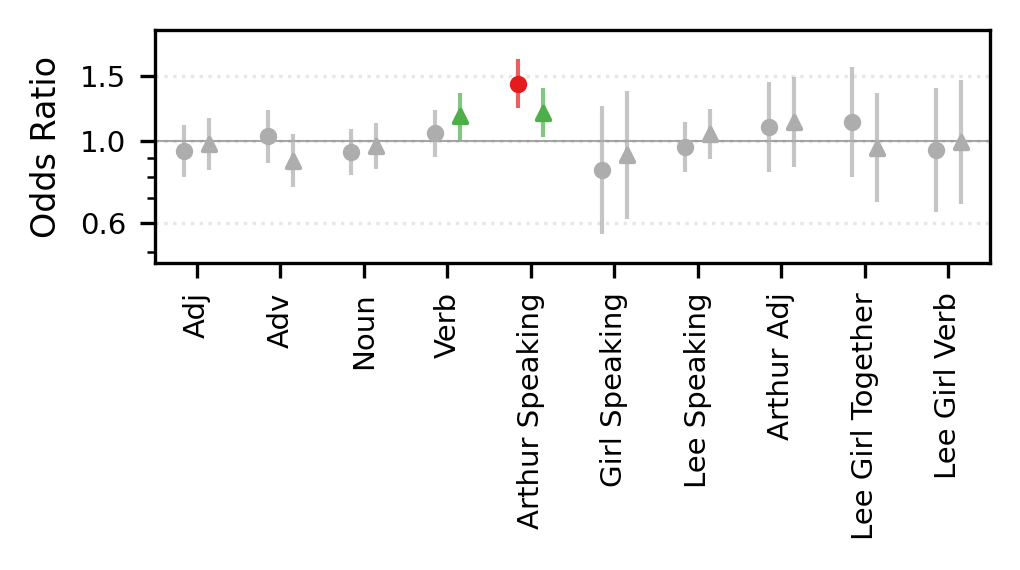

In [22]:
results1_3 = load_glmm_results(
    output_dir=OUTPUT_DIR,
    cluster_id=1,
    data_type="combined",
    model_pattern="3states"
)
plot_brain_state_effects(results1_3, custom_feature_order=plot_features, save_path="glmm_brain_3states_cluster1")

Found 10 features in data


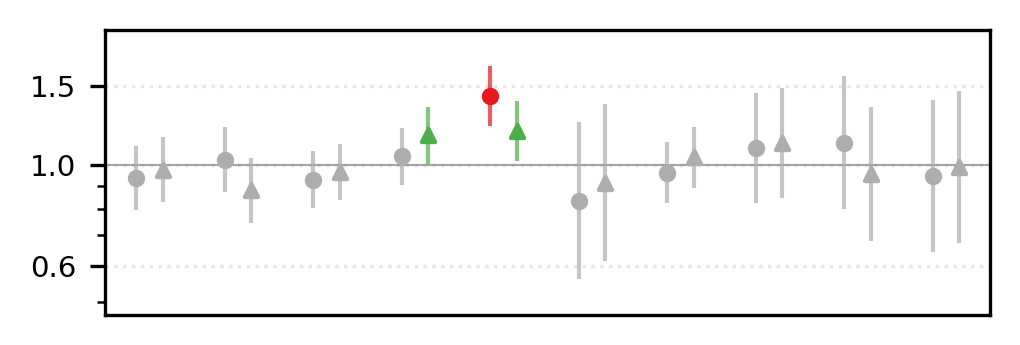

In [23]:
plot_brain_state_effects(results1_3, custom_feature_order=plot_features, label=False, save_path="glmm_brain_3states_cluster1")

Found 10 features in data


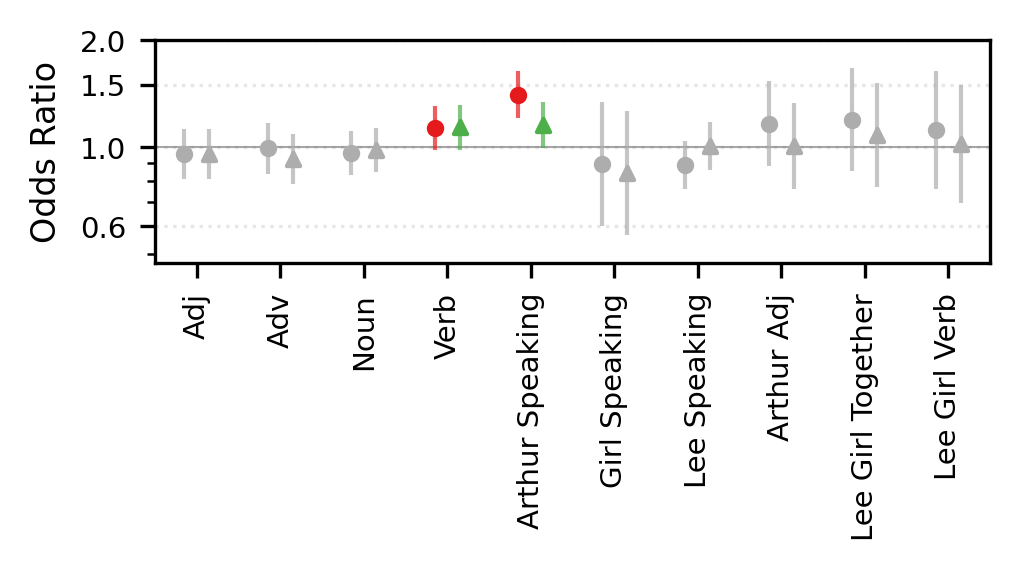

In [24]:
results1_4 = load_glmm_results(
    output_dir=OUTPUT_DIR,
    cluster_id=1,
    data_type="combined",
    model_pattern="4states"
)
plot_brain_state_effects(results1_4, custom_feature_order=plot_features, save_path="glmm_brain_4states_cluster1")

Found 10 features in data


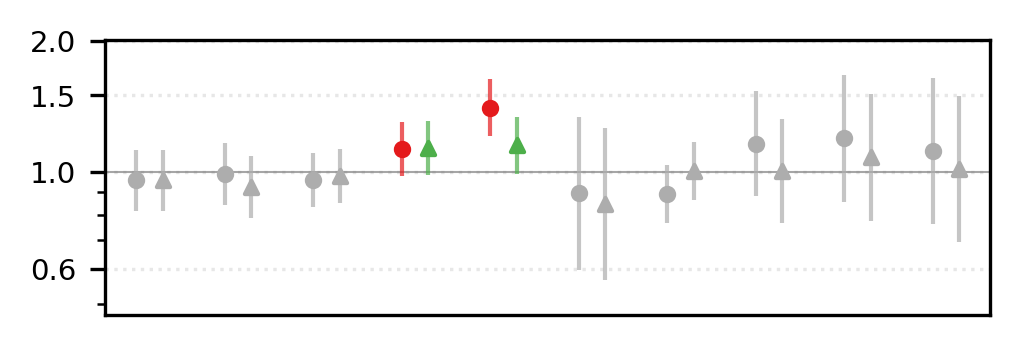

In [25]:
plot_brain_state_effects(results1_4, custom_feature_order=plot_features, label=False, save_path="glmm_brain_4states_cluster1")

Found 10 features in data


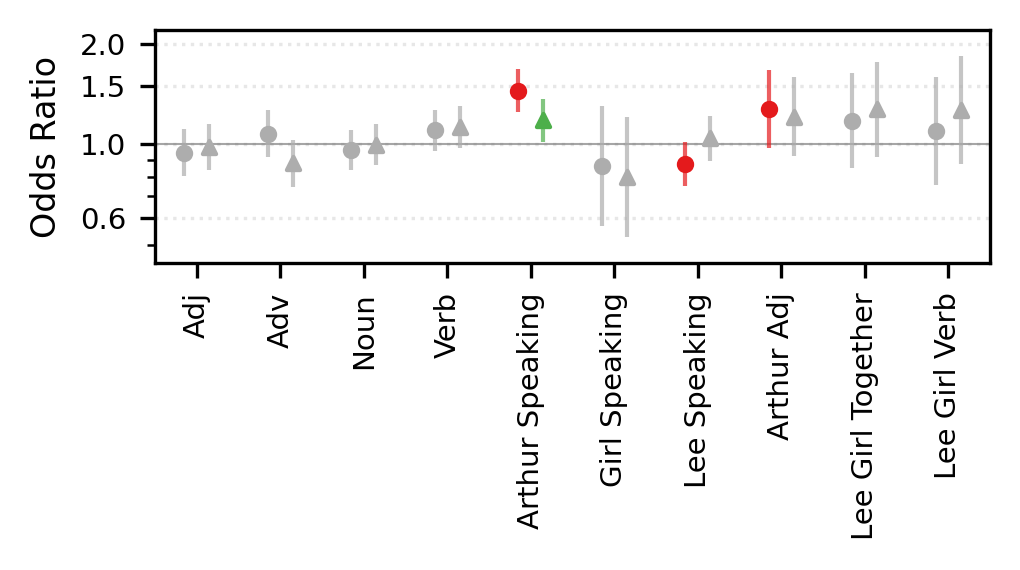

In [26]:

results1_5 = load_glmm_results(
    output_dir=OUTPUT_DIR,
    cluster_id=1,
    data_type="combined",
    model_pattern="5states"
)
plot_brain_state_effects(results1_5, custom_feature_order=plot_features, save_path="glmm_brain_5states_cluster1")

Found 10 features in data


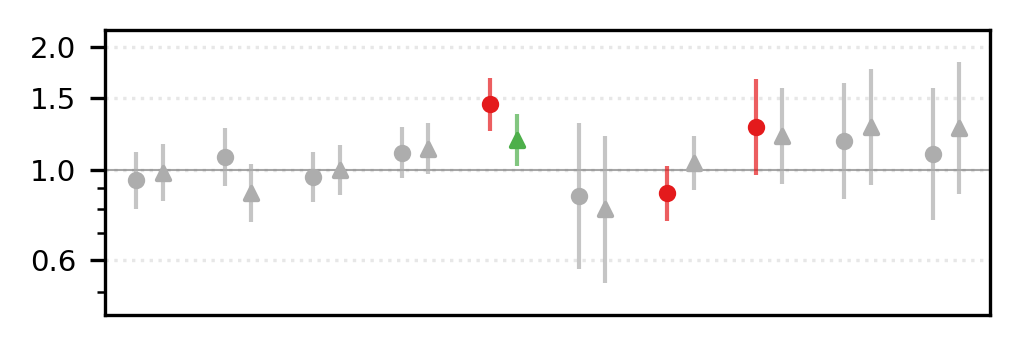

In [27]:
plot_brain_state_effects(results1_5, custom_feature_order=plot_features, label=False, save_path="glmm_brain_5states_cluster1")

Found 10 features in data


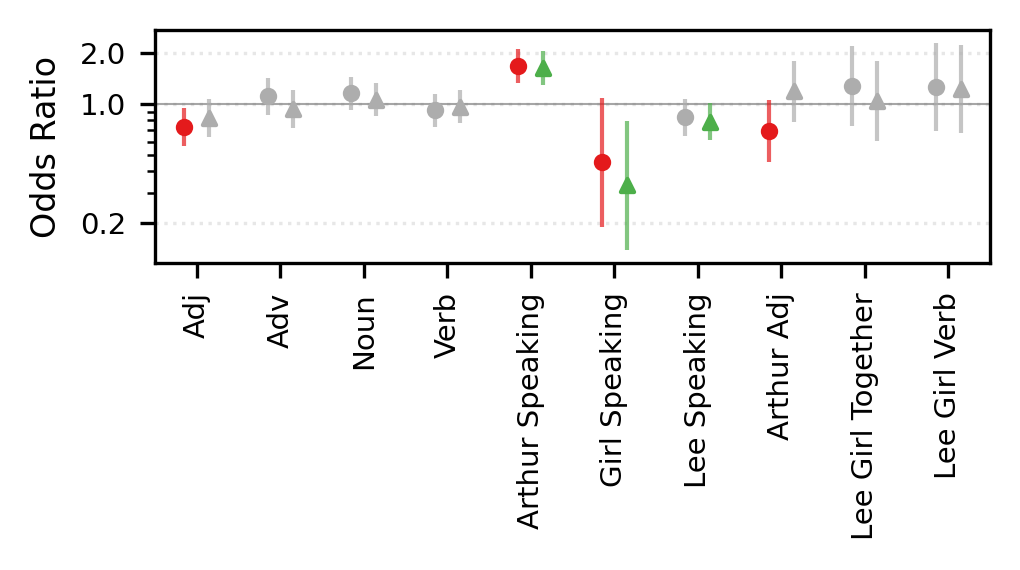

In [38]:
results2 = load_glmm_results(
    output_dir=OUTPUT_DIR,
    cluster_id=2,
    data_type="combined",
    model_pattern="12states"
)
plot_brain_state_effects(results2, custom_feature_order=plot_features, save_path="glmm_brain_12states_cluster2", y_ticks=[0.2, 1.0, 2.0])

Found 10 features in data


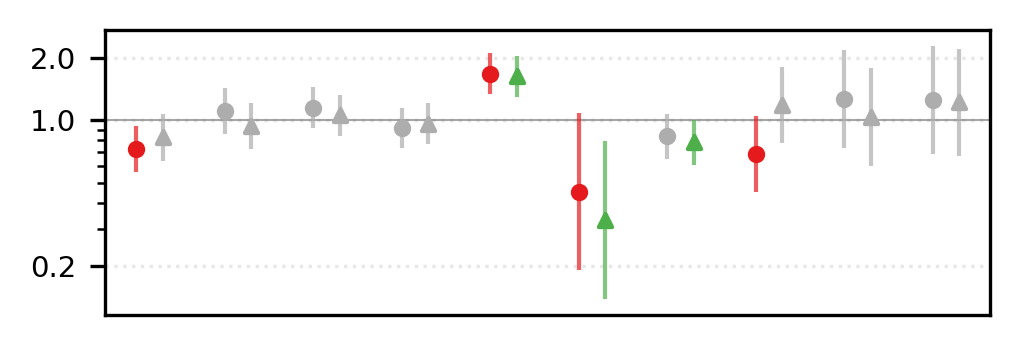

In [41]:
plot_brain_state_effects(results2, custom_feature_order=plot_features, label=False, save_path="glmm_brain_12states_cluster2", y_ticks=[0.2, 1.0, 2.0])

Found 10 features in data


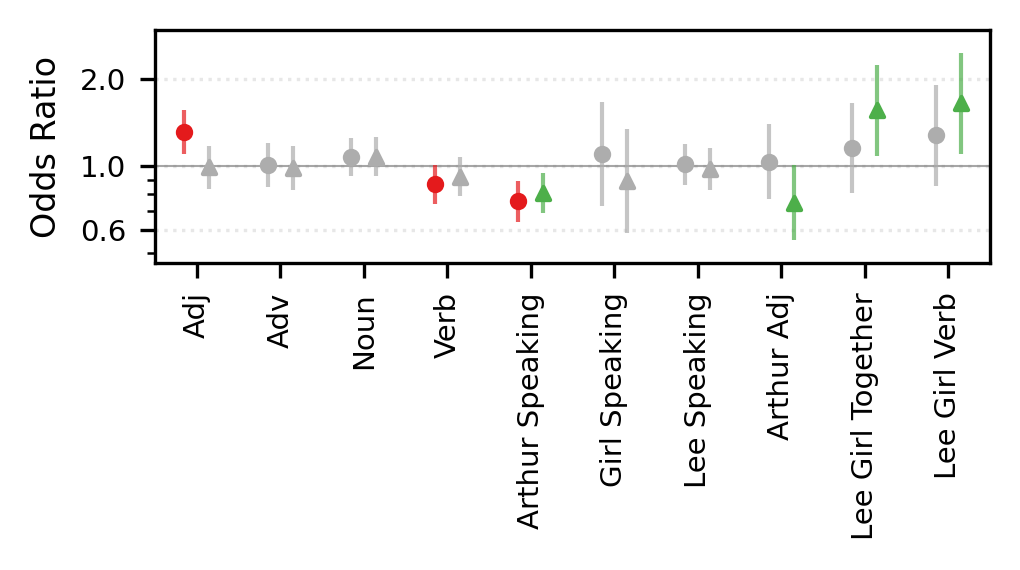

In [40]:

results3 = load_glmm_results(
    output_dir=OUTPUT_DIR,
    cluster_id=3,
    data_type="combined",
    model_pattern="2states"
)
plot_brain_state_effects(results3, custom_feature_order=plot_features, save_path="glmm_brain_2states_cluster3", y_ticks=[0.6, 1.0, 2.0])

Found 10 features in data


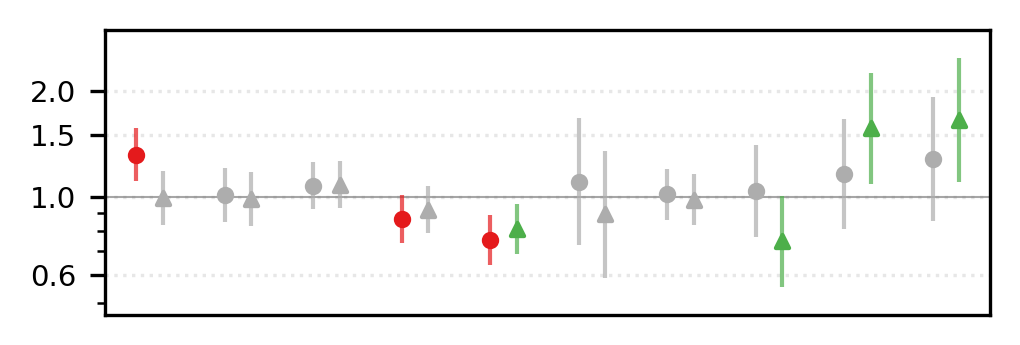

In [42]:
plot_brain_state_effects(results3, custom_feature_order=plot_features, label=False, save_path="glmm_brain_2states_cluster3")


Found 10 features in data


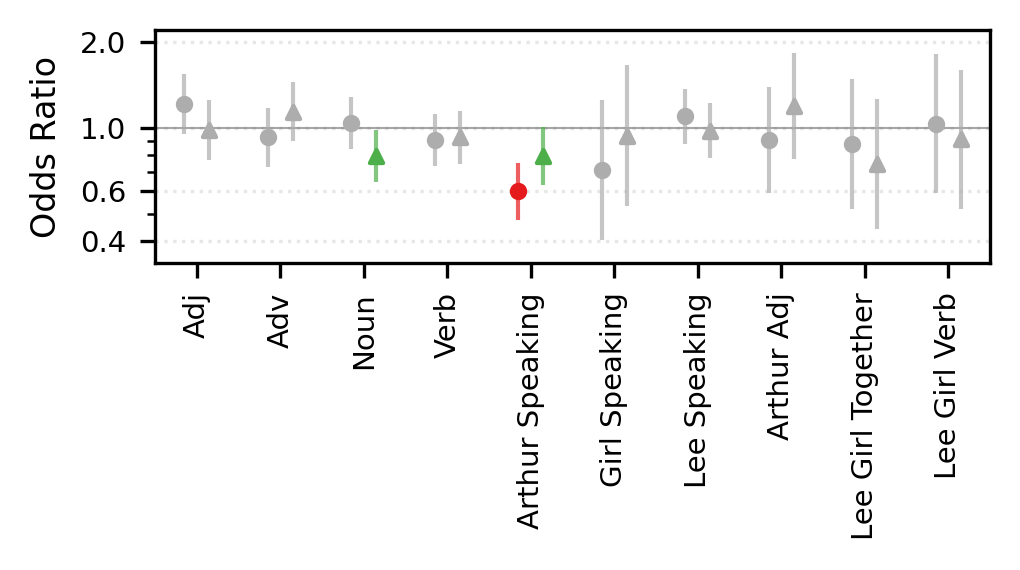

In [44]:
results4 = load_glmm_results(   
    output_dir=OUTPUT_DIR,
    cluster_id=4,
    data_type="combined",
    model_pattern="8states" 
)
plot_brain_state_effects(results4, custom_feature_order=plot_features, save_path="glmm_brain_8states_cluster4", y_ticks=[0.4, 0.6,1.0, 2.0])

Found 10 features in data


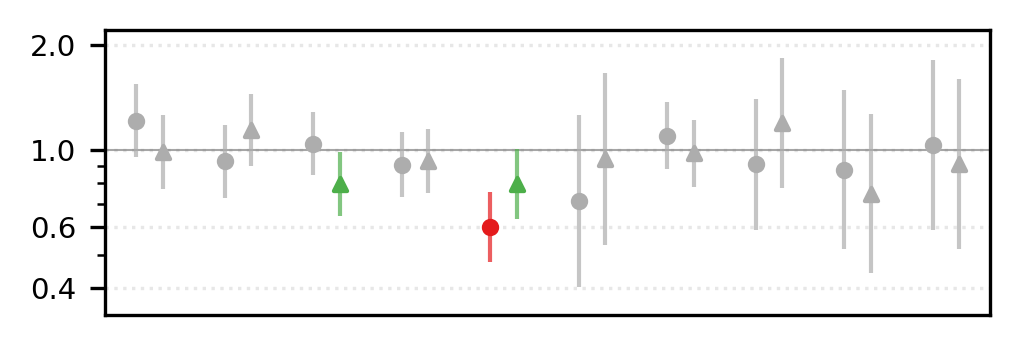

In [45]:
plot_brain_state_effects(results4, custom_feature_order=plot_features, label=False, save_path="glmm_brain_8states_cluster4", y_ticks=[0.4, 0.6,1.0, 2.0])